In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [20]:
# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

In [22]:
# Load dataset
df = pd.read_csv('D:\My DS Projects\Classification-Heart-Failure-Prediction\heart.csv')
df 


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [23]:
# Display a concise summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [24]:
# Define the continuous features
continuous_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease       object
dtype: object

In [25]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


In [26]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918
unique,2,4,2,3,2,3,2
top,M,ASY,0,Normal,N,Flat,1
freq,725,496,704,552,547,460,508


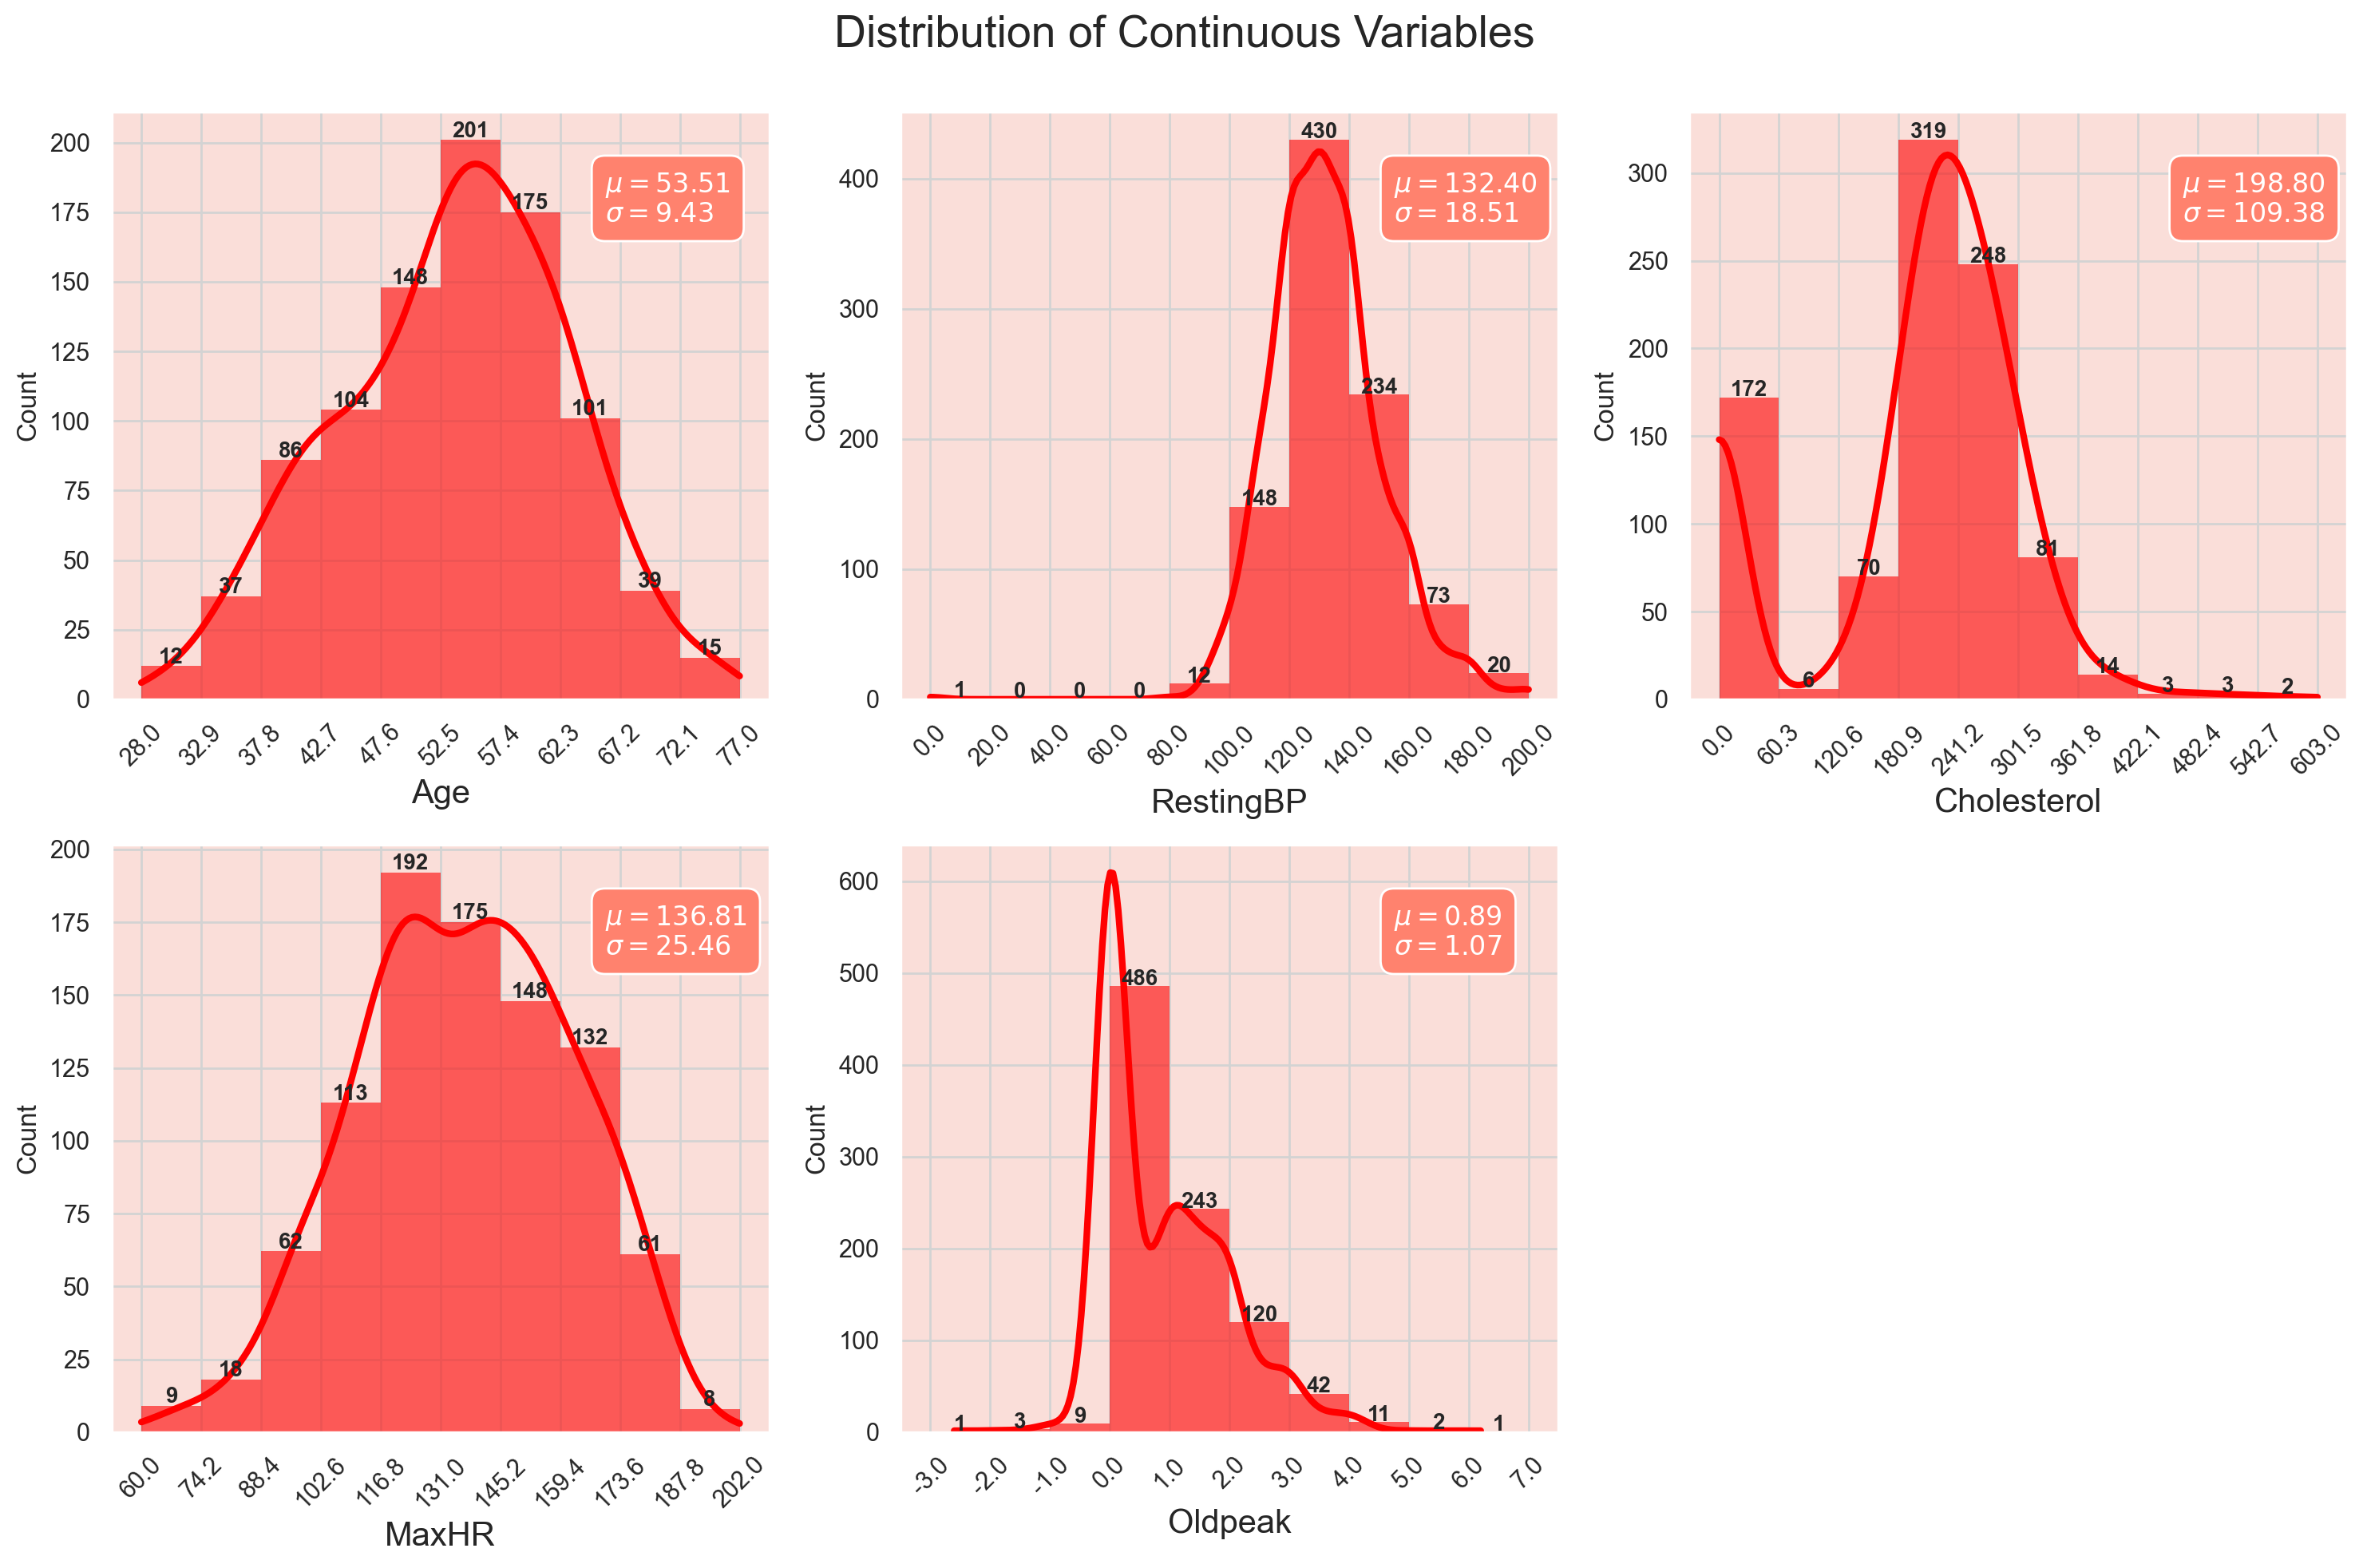

In [27]:
# Filter out continuous features for the univariate analysis
df_continuous = df[continuous_features]

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[1,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [28]:
# Filter out categorical features for the univariate analysis
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]

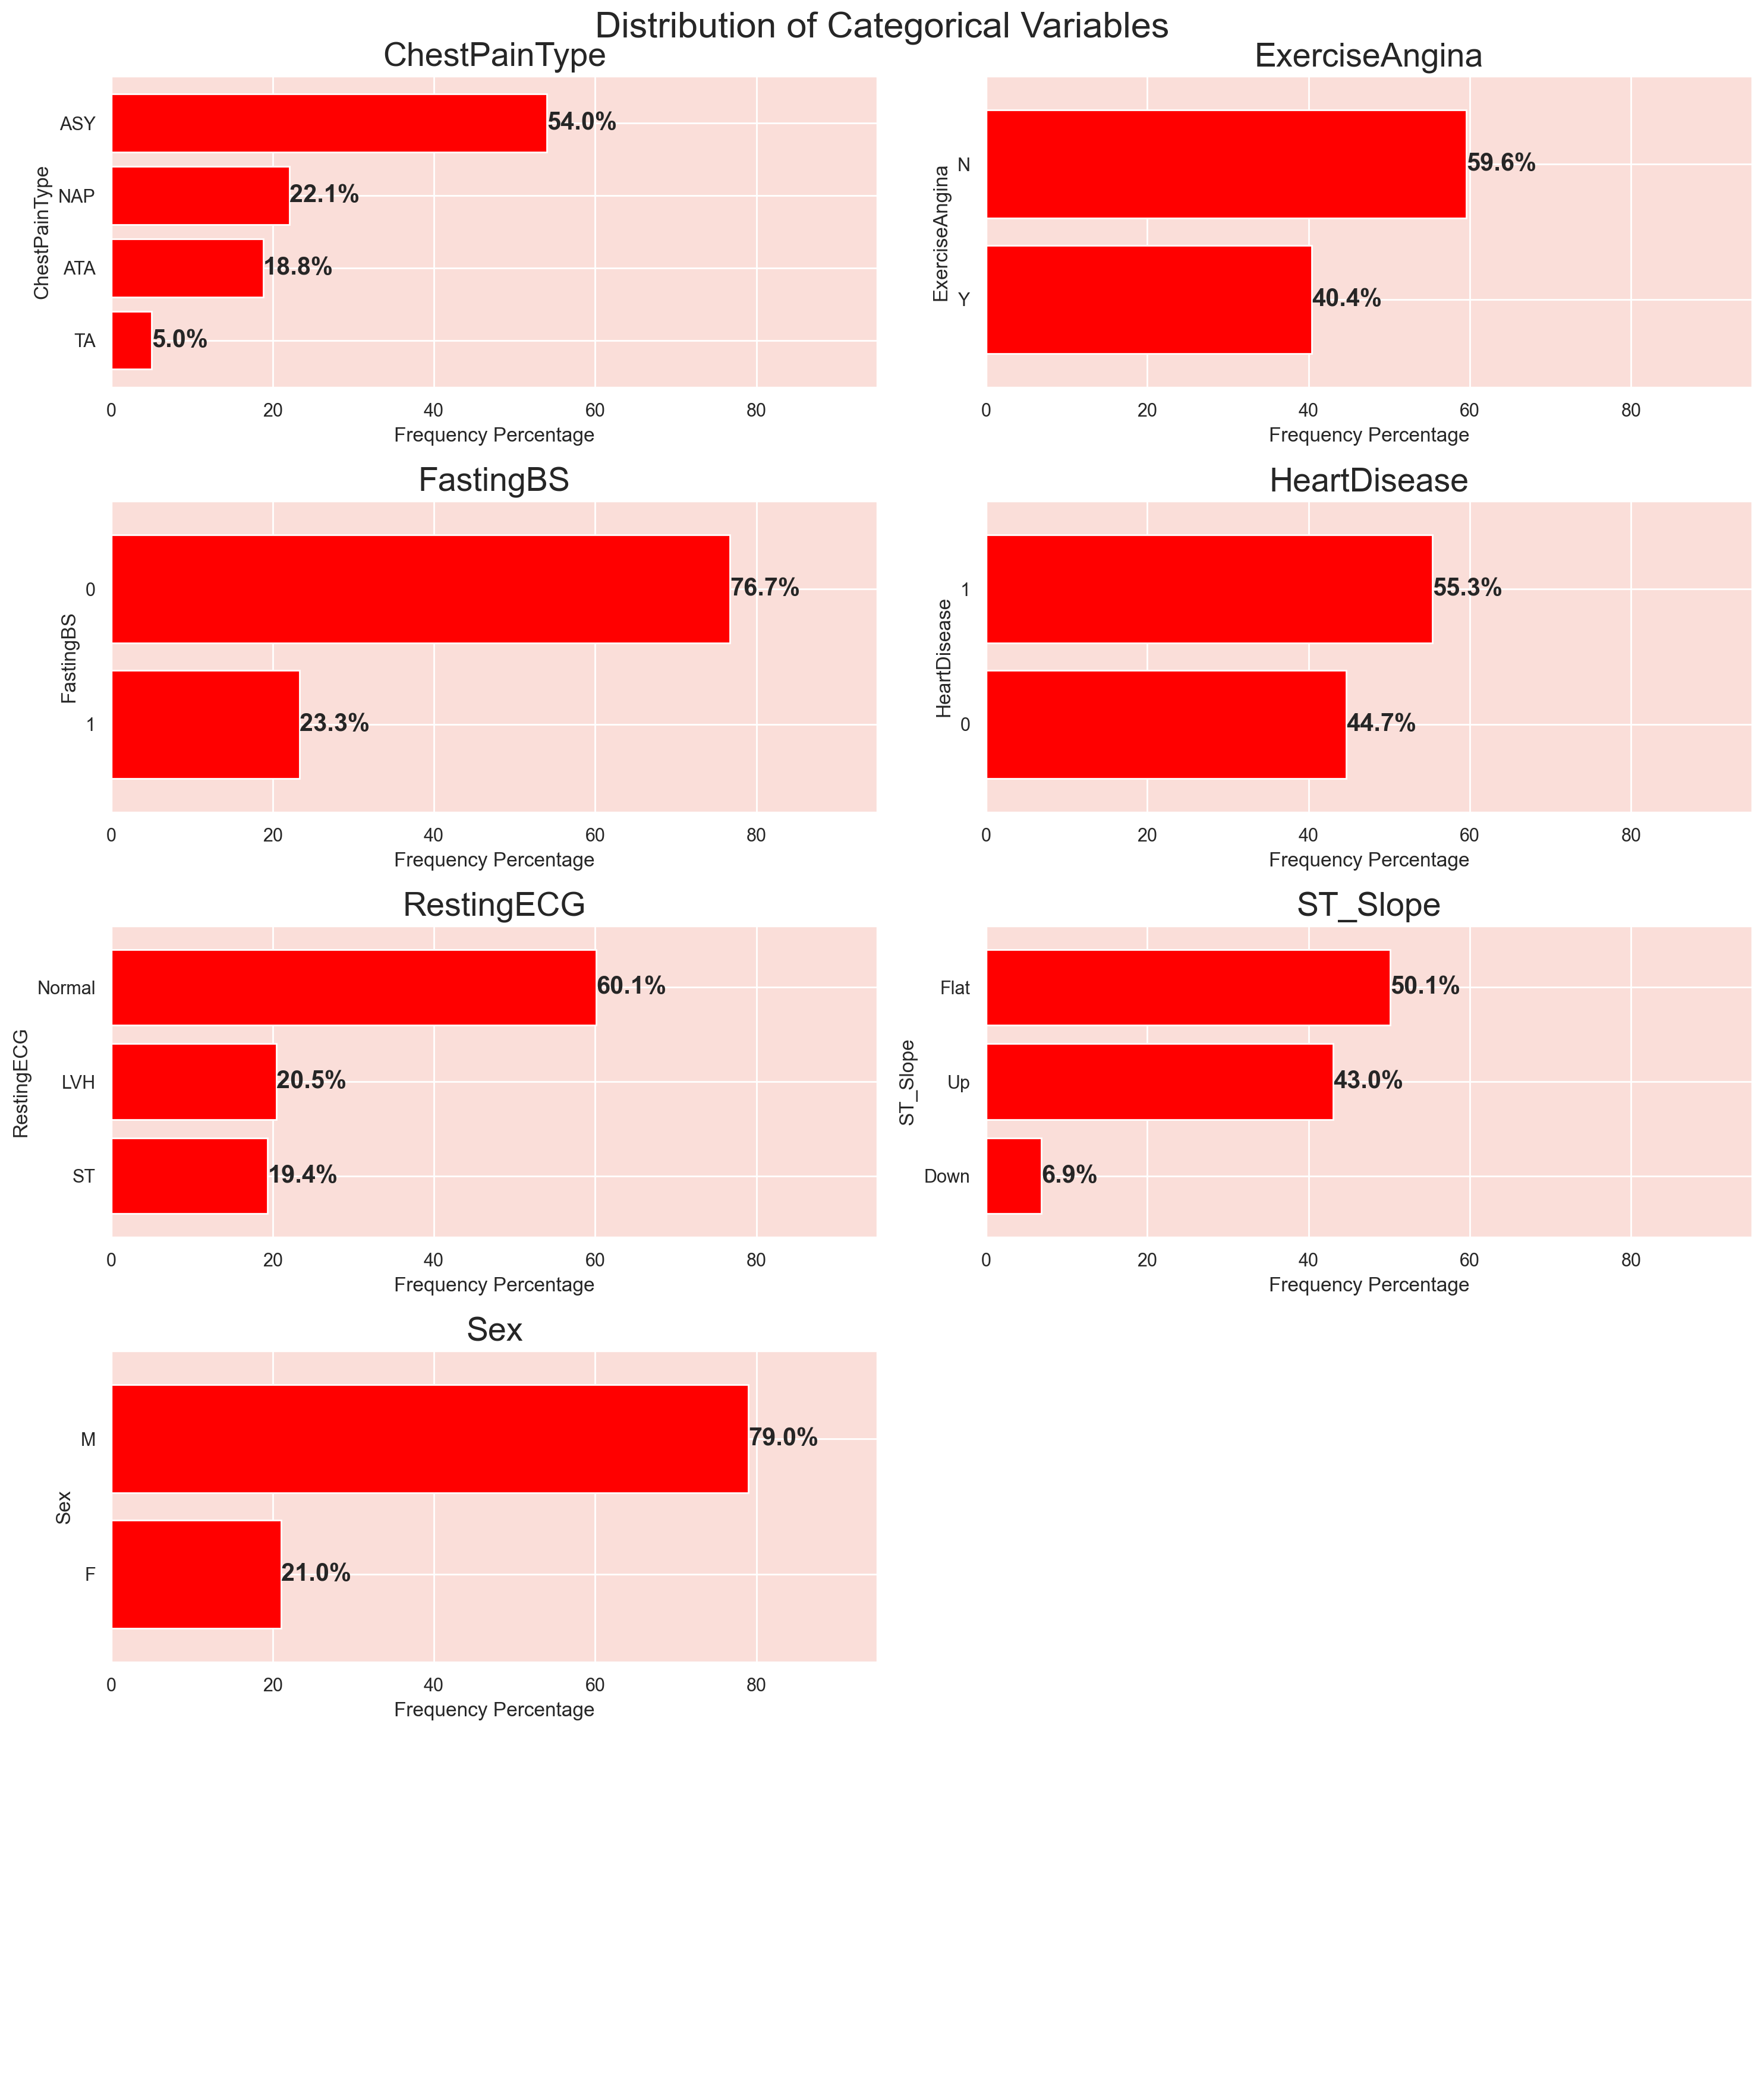

In [29]:
# Set up the subplot for a 4x2 layout
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 4x2 layout
for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2
    
    # Calculate frequency percentages
    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    
    # Plot bar chart
    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='red')
    
    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')
    
    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{col}', fontsize=20)

ax[3,1].axis('off')    
ax[4,1].axis('off')
ax[4,0].axis('off')
plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


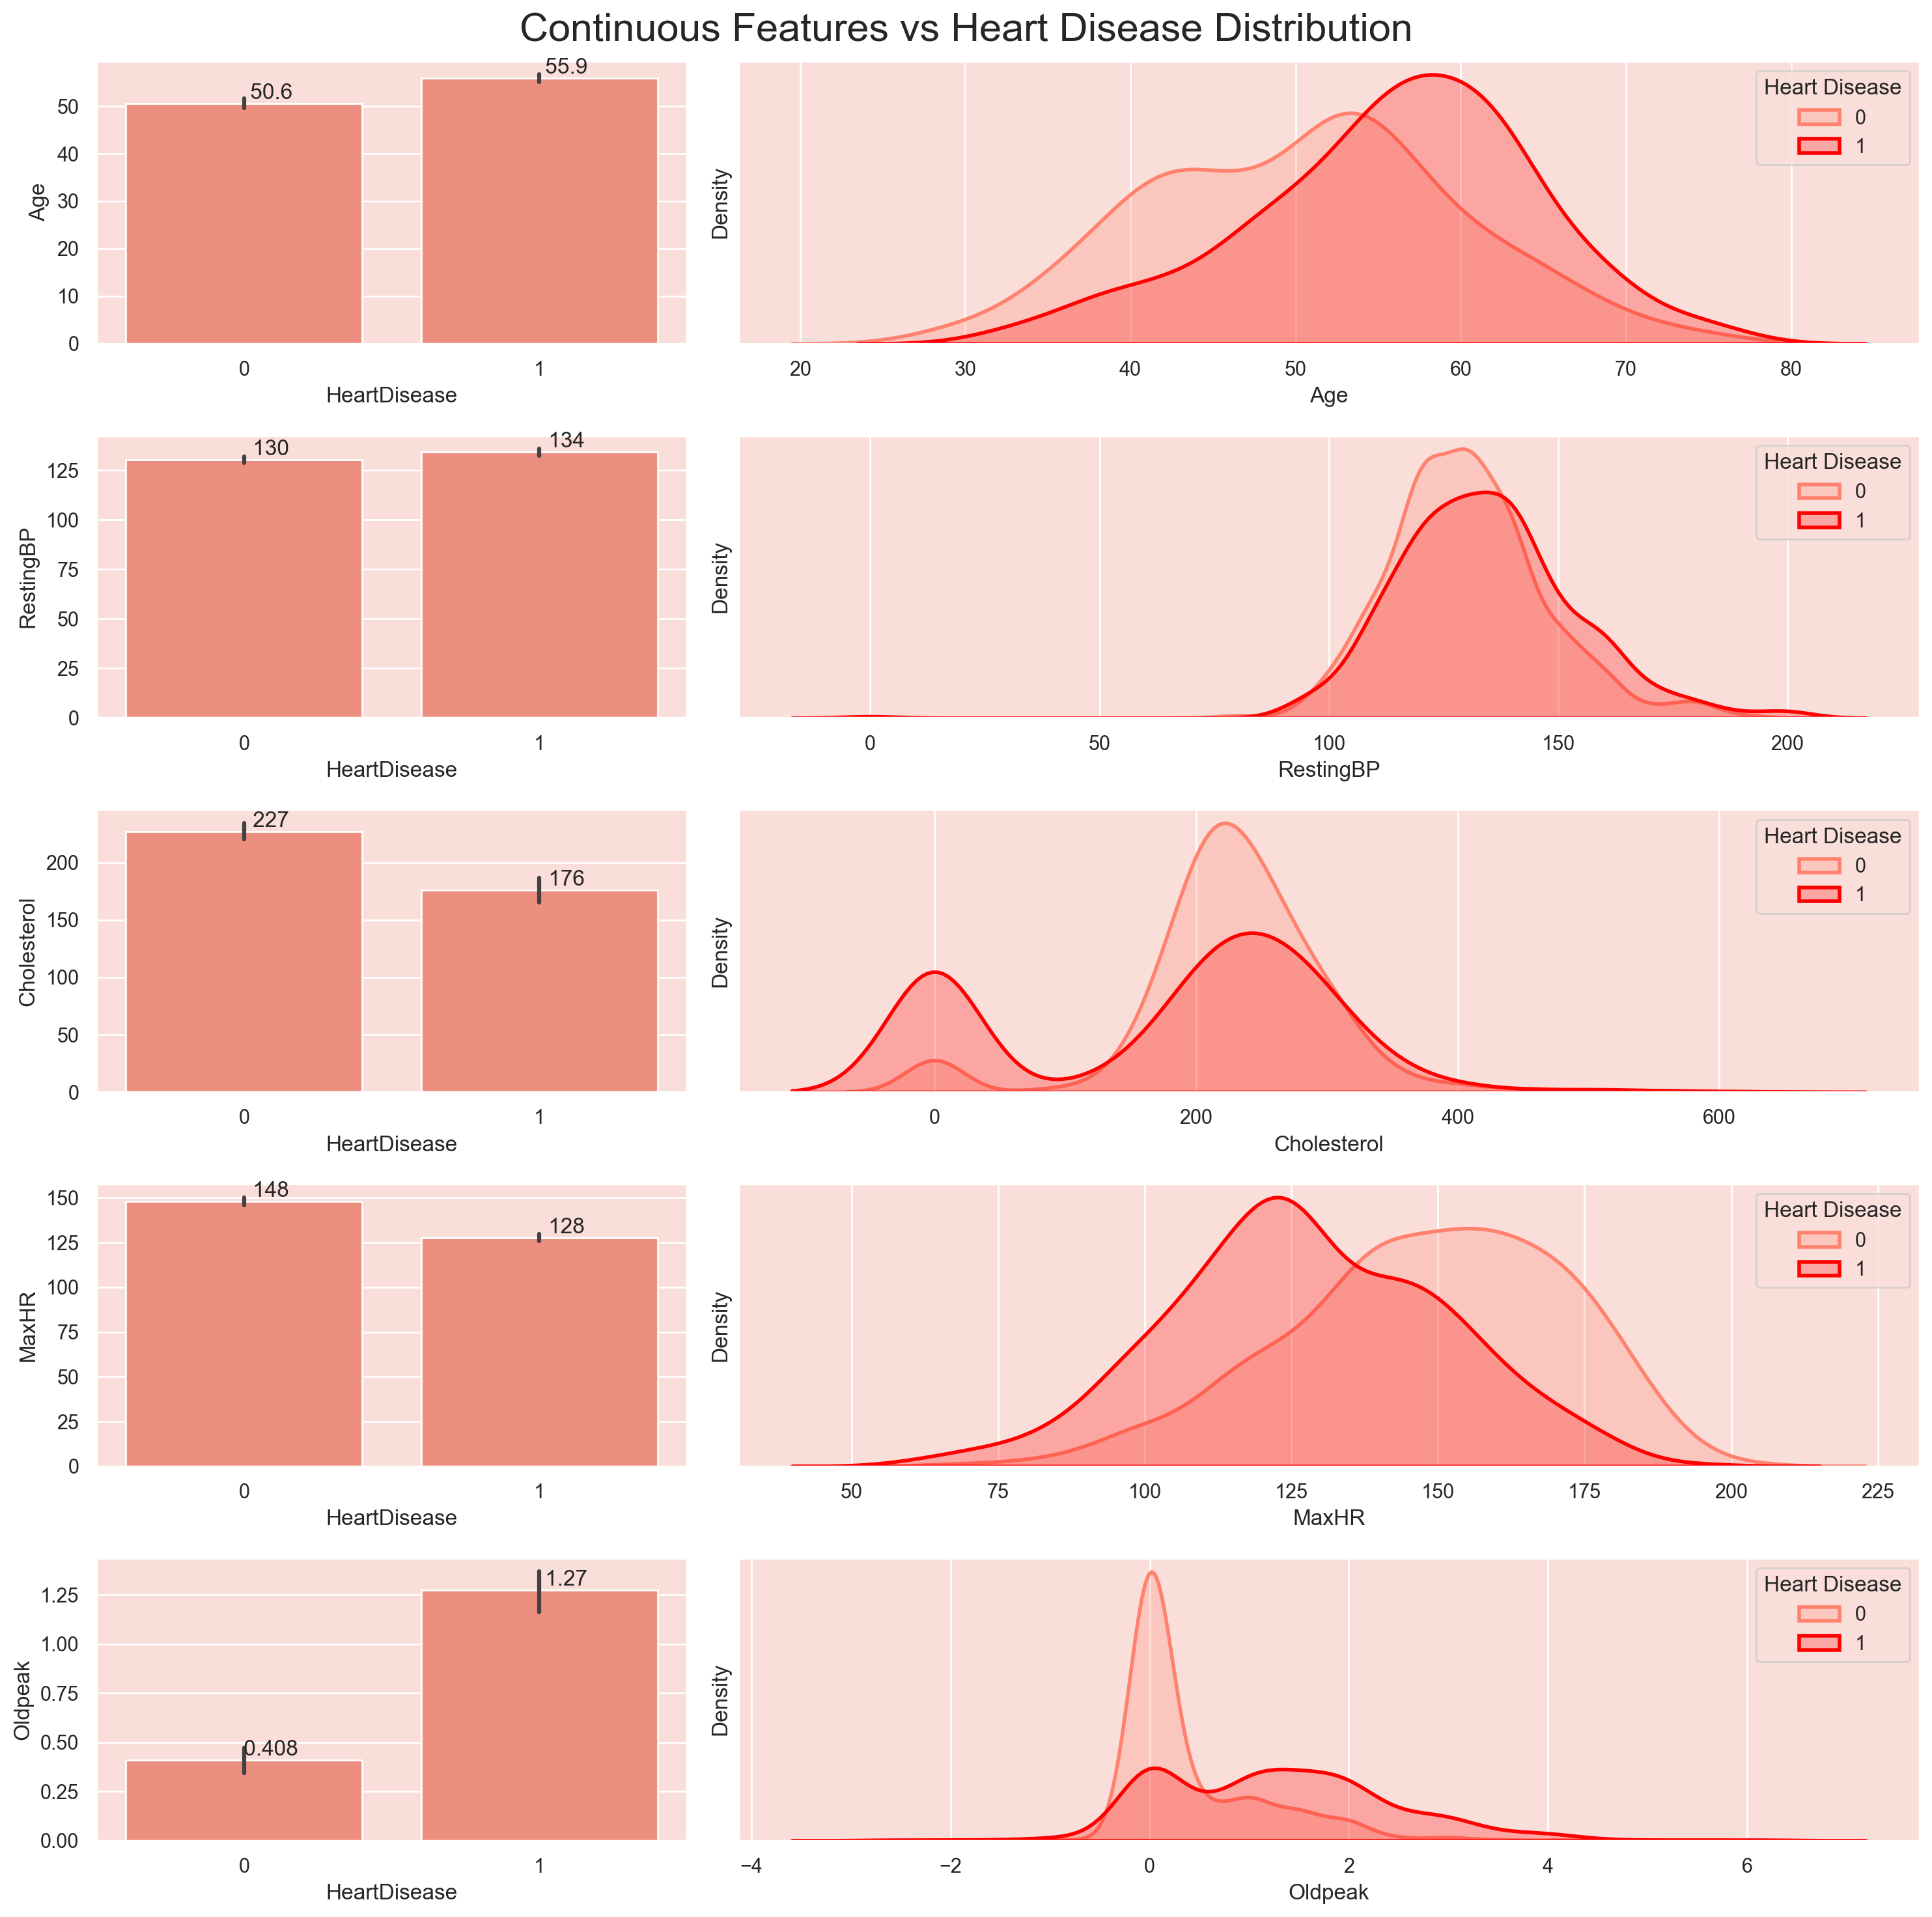

In [30]:
# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each HeartDisease category
    graph = sns.barplot(data=df, x="HeartDisease", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each HeartDisease category
    sns.kdeplot(data=df[df["HeartDisease"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df["HeartDisease"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Heart Disease', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Heart Disease Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

In [31]:
# Remove 'HeartDisease' from the categorical_features
categorical_features = [feature for feature in categorical_features if feature != 'HeartDisease']

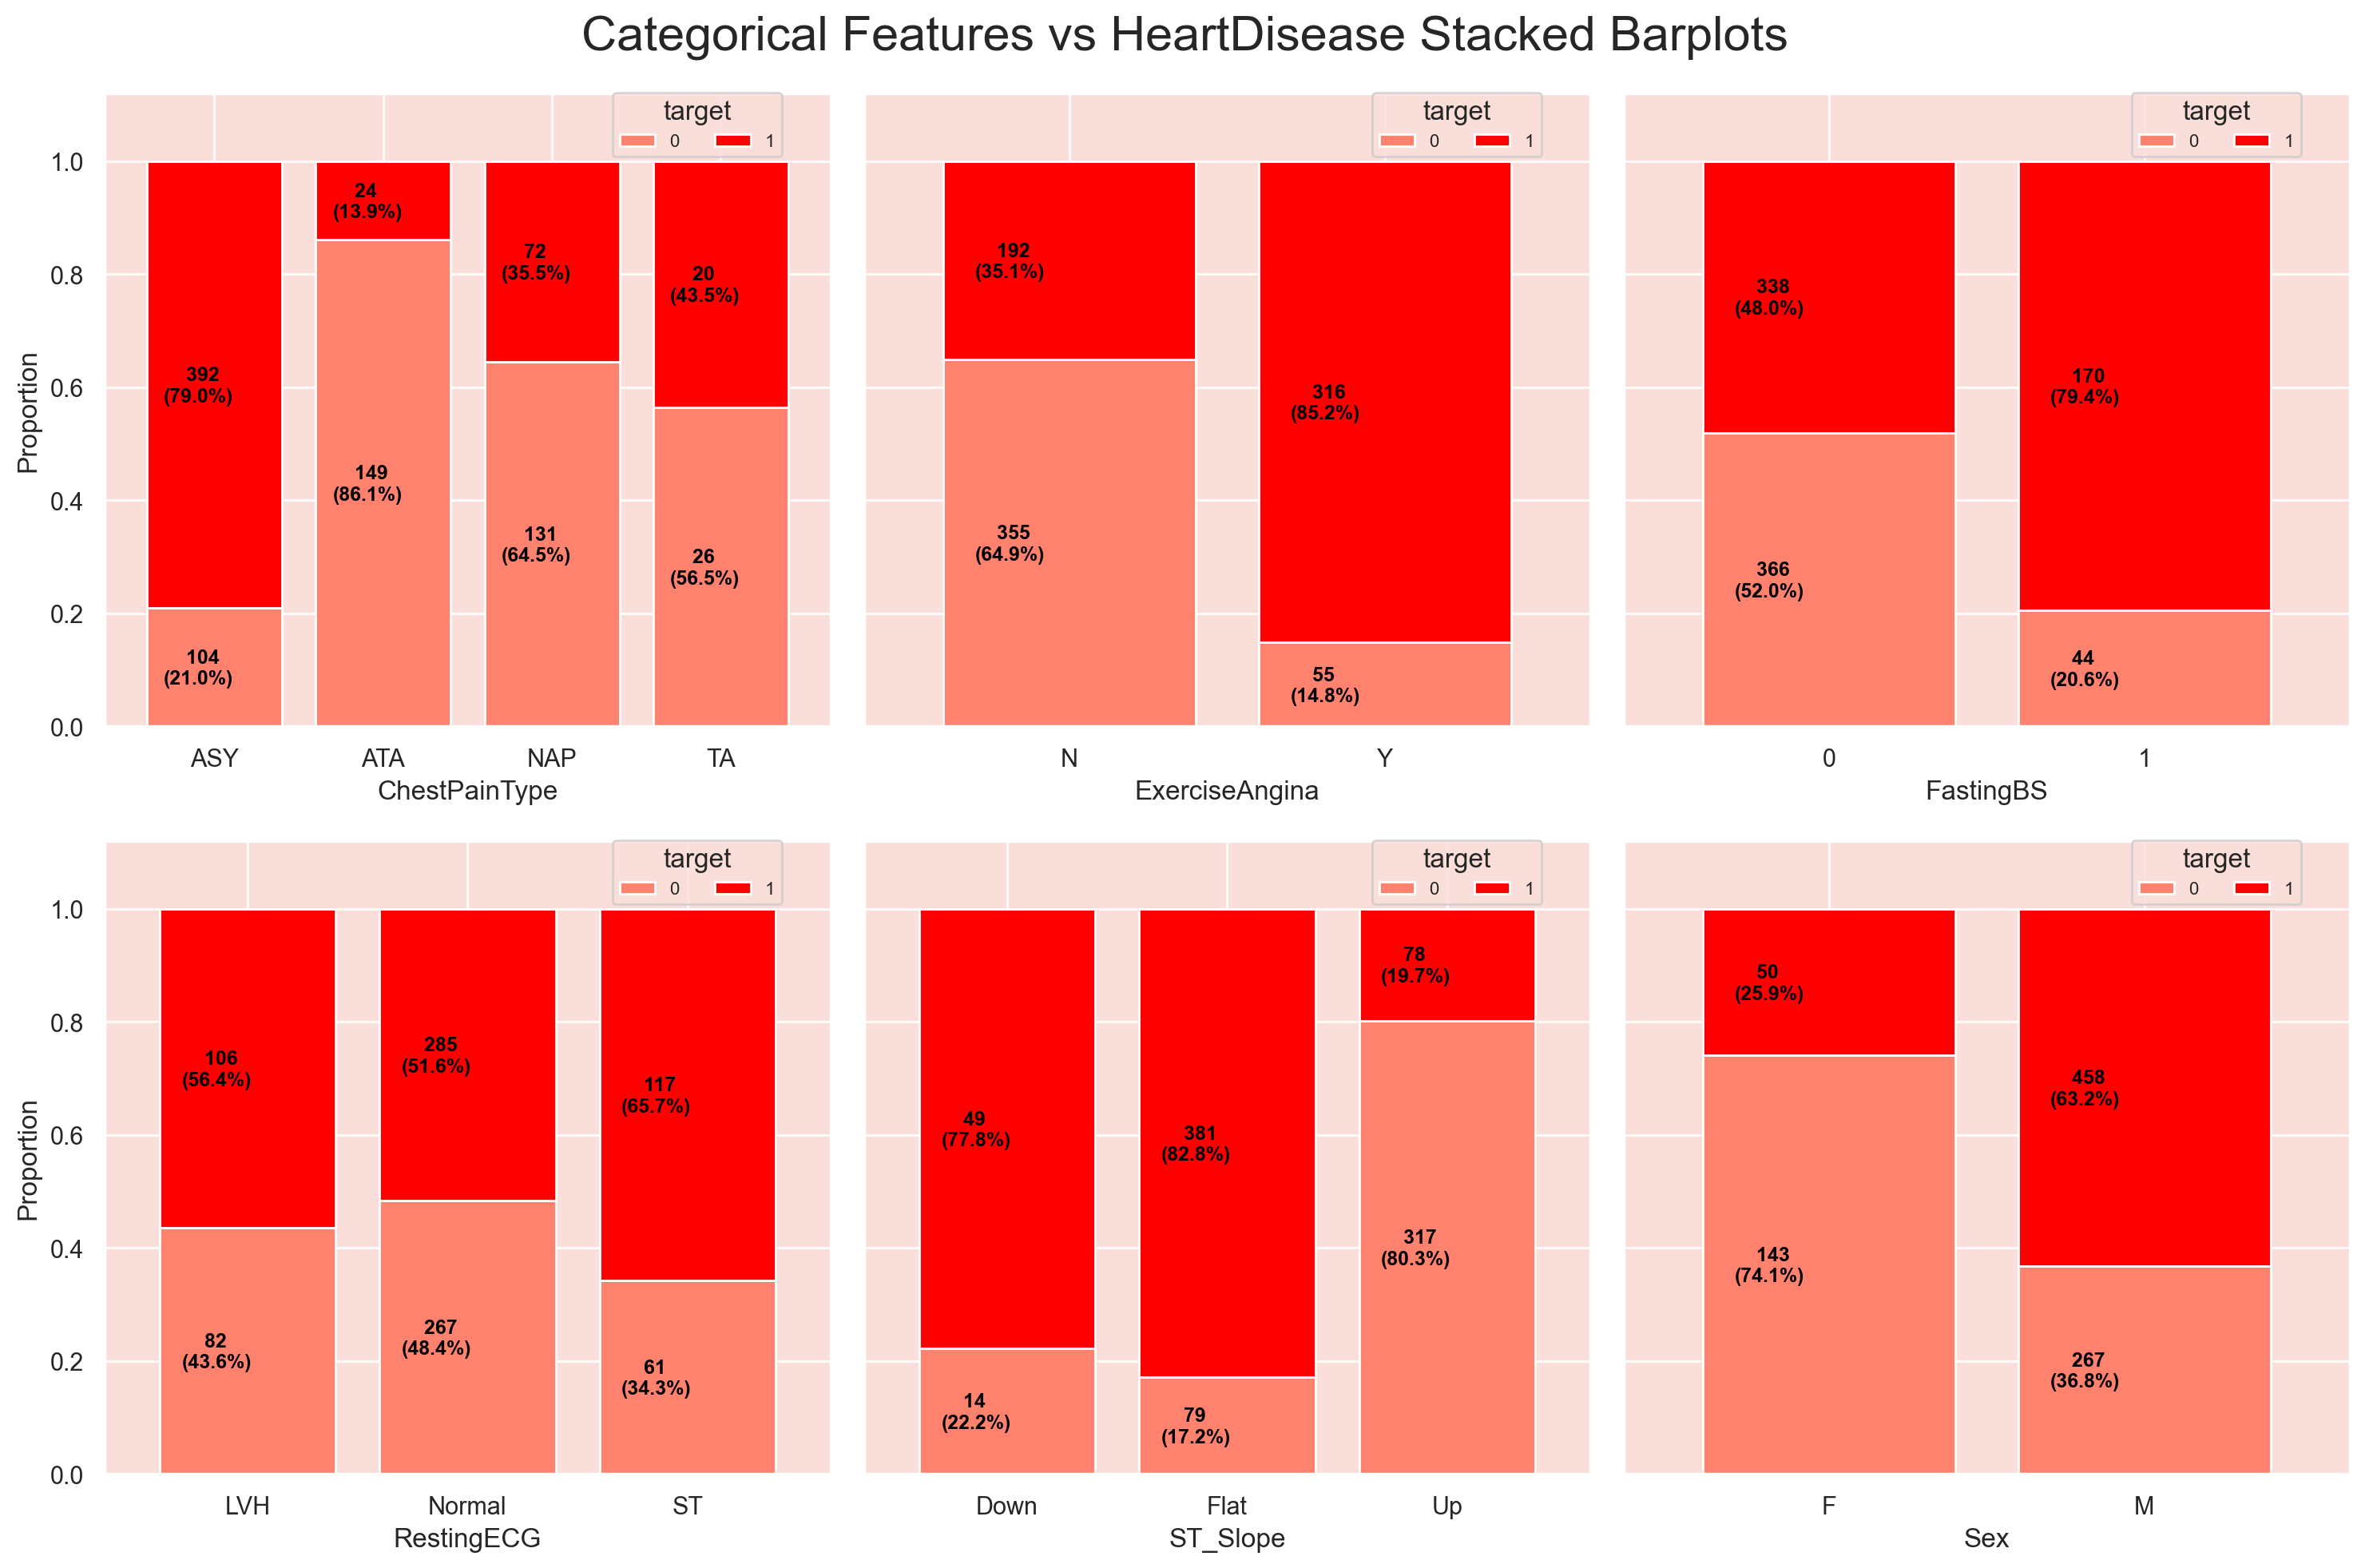

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for i,col in enumerate(categorical_features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df['HeartDisease'])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['HeartDisease'], normalize='index')

    # Define colormap
    cmp = ListedColormap(['#ff826e', 'red'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.3, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'    {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='target', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
    
            
plt.suptitle('Categorical Features vs HeartDisease Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

In [33]:
# Check for missing values in the dataset
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [34]:
continuous_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [35]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

Age              0
RestingBP       28
Cholesterol    183
MaxHR            2
Oldpeak         16
dtype: int64

In [36]:
# Implementing one-hot encoding on the specified categorical features
df_encoded = pd.get_dummies(df, columns=['Sex', 'ChestPainType',  'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)
df_encoded = df_encoded.astype(int)

df_encoded.dtypes

Age                  int32
RestingBP            int32
Cholesterol          int32
MaxHR                int32
Oldpeak              int32
HeartDisease         int32
Sex_M                int32
ChestPainType_ATA    int32
ChestPainType_NAP    int32
ChestPainType_TA     int32
FastingBS_1          int32
RestingECG_Normal    int32
RestingECG_ST        int32
ExerciseAngina_Y     int32
ST_Slope_Flat        int32
ST_Slope_Up          int32
dtype: object

In [37]:
df_encoded

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,172,0,0,1,1,0,0,0,1,0,0,0,1
1,49,160,180,156,1,1,0,0,1,0,0,1,0,0,1,0
2,37,130,283,98,0,0,1,1,0,0,0,0,1,0,0,1
3,48,138,214,108,1,1,0,0,0,0,0,1,0,1,1,0
4,54,150,195,122,0,0,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,132,1,1,1,0,0,1,0,1,0,0,1,0
914,68,144,193,141,3,1,1,0,0,0,1,1,0,0,1,0
915,57,130,131,115,1,1,1,0,0,0,0,1,0,1,1,0
916,57,130,236,174,0,1,0,1,0,0,0,0,0,0,1,0


In [38]:
# Define the features (X) and the output labels (y)
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

In [39]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [40]:
continuous_features

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [41]:
# Adding a small constant to 'oldpeak' to make all values positive
X_train['Oldpeak'] = X_train['Oldpeak'] + 0.001
X_test['Oldpeak'] = X_test['Oldpeak'] + 0.001

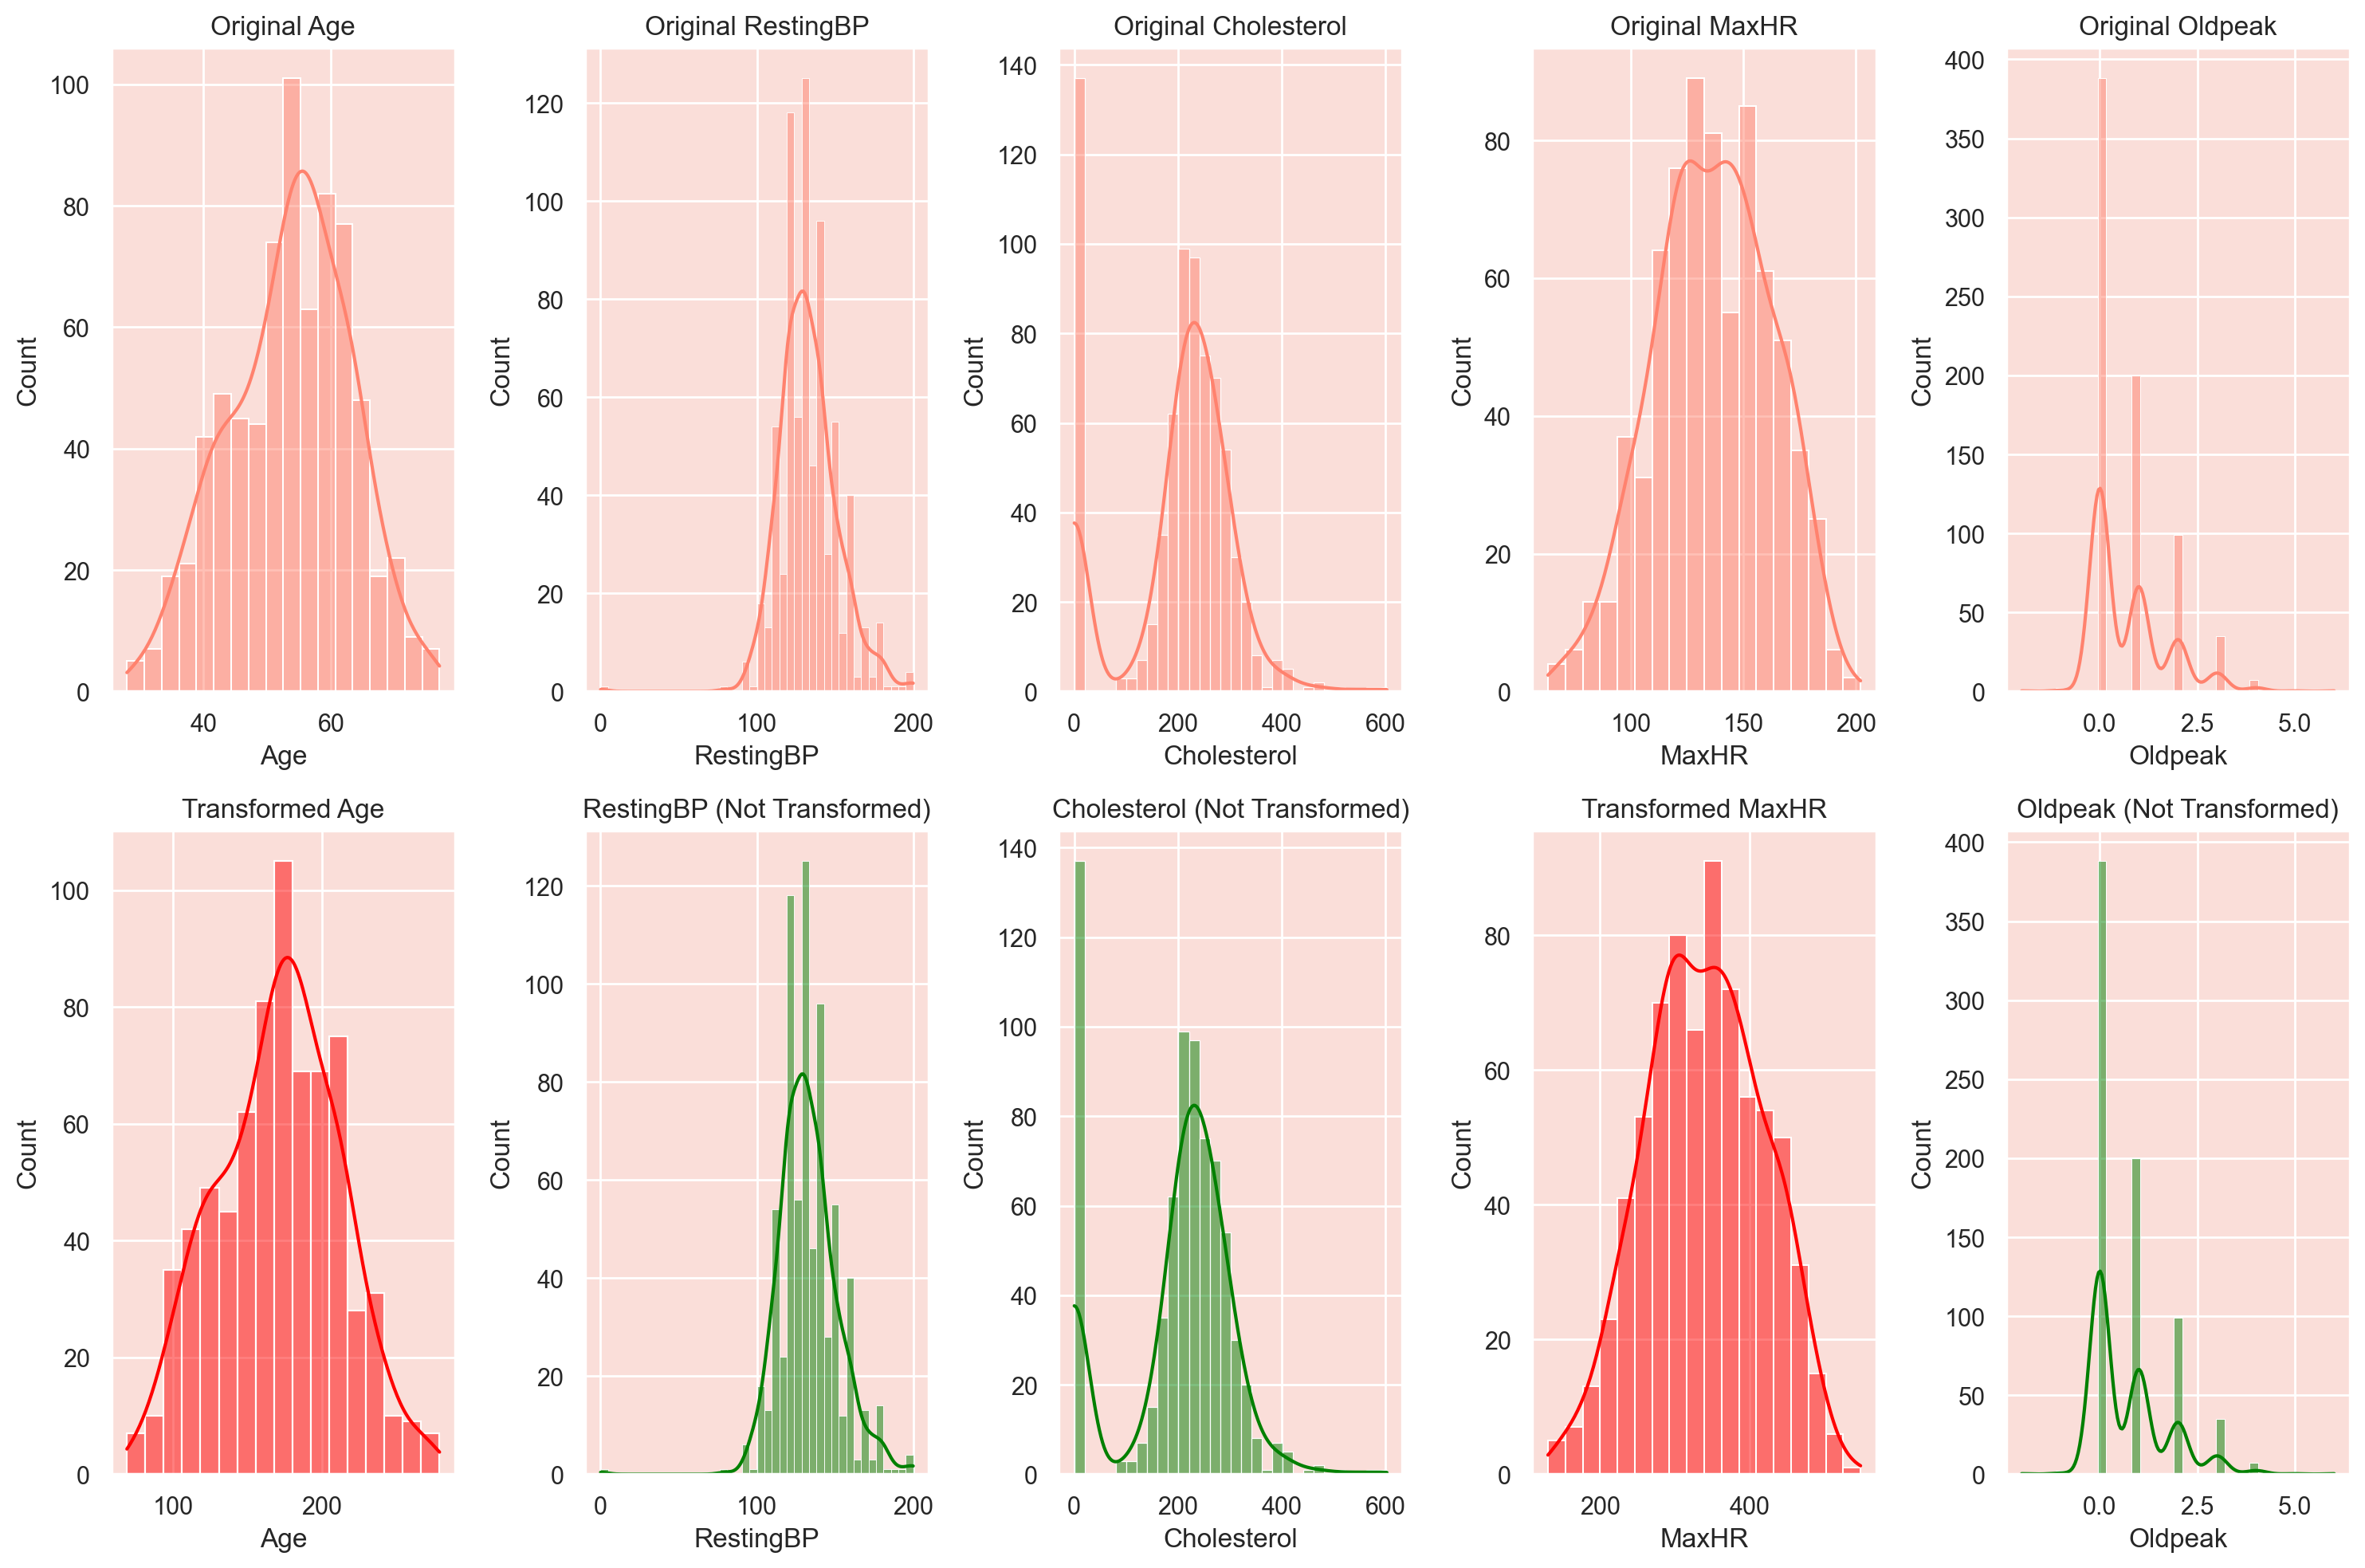

In [42]:
# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15,10))

# Original Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')
    

# Applying Box-Cox Transformation
# Dictionary to store lambda values for each feature
lambdas = {}

for i, col in enumerate(continuous_features):
    # Only apply box-cox for positive values
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        # Applying the same lambda to test data
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col]) 
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

In [43]:
X_train.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
146,121.116369,120,198,395.667557,0.001,1,1,0,0,0,1,0,0,0,1
805,171.152225,140,239,411.414249,1.001,1,0,0,0,0,1,0,0,0,1
473,197.821310,141,316,294.766365,1.001,1,0,1,0,1,0,1,1,1,0
707,171.152225,124,266,256.608559,2.001,1,0,0,0,0,0,0,1,1,0
242,175.524574,160,292,358.349425,2.001,1,1,0,0,1,1,0,1,1,0


In [45]:
# Define the base DT model
dt_base = DecisionTreeClassifier(random_state=0)

In [46]:
#DT Hyperparameter Tuning
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest recall for class 1 is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [47]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

In [48]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

In [49]:
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [50]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       328
           1       0.84      0.90      0.87       406

    accuracy                           0.85       734
   macro avg       0.85      0.84      0.85       734
weighted avg       0.85      0.85      0.85       734



In [51]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        82
           1       0.87      0.85      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [52]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluates the performance of a trained model on test data using various metrics.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to dataframe
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [53]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.82,0.87,0.84,0.85,0.83,0.86,0.85,0.85,0.85,0.85


In [54]:
# Random Forrest Base Model
rf_base = RandomForestClassifier(random_state=0)

In [55]:
#RF Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [56]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

RF Optimal Hyperparameters: 
 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [58]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       328
           1       0.86      0.94      0.90       406

    accuracy                           0.88       734
   macro avg       0.89      0.87      0.88       734
weighted avg       0.88      0.88      0.88       734



In [59]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



In [60]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.86,0.88,0.85,0.89,0.86,0.89,0.87,0.87,0.87,0.88


In [61]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [62]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [63]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'distance'}


In [64]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00       406

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



In [65]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        82
           1       0.92      0.88      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [66]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.86,0.92,0.9,0.88,0.88,0.9,0.89,0.89,0.89,0.89


In [72]:
#SVM Base Model
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

In [73]:
#SVM Hyperparameter Tunning
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [74]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [75]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       328
           1       0.55      1.00      0.71       406

    accuracy                           0.55       734
   macro avg       0.28      0.50      0.36       734
weighted avg       0.31      0.55      0.39       734



In [76]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.55      1.00      0.71       102

    accuracy                           0.55       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.55      0.40       184



In [77]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.0,0.55,0.0,1.0,0.0,0.71,0.28,0.5,0.36,0.55


In [78]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.00,0.55,0.00,1.00,0.00,0.71,0.28,0.50,0.36,0.55
RF,0.86,0.88,0.85,0.89,0.86,0.89,0.87,0.87,0.87,0.88
KNN,0.86,0.92,0.90,0.88,0.88,0.90,0.89,0.89,0.89,0.89
DT,0.82,0.87,0.84,0.85,0.83,0.86,0.85,0.85,0.85,0.85


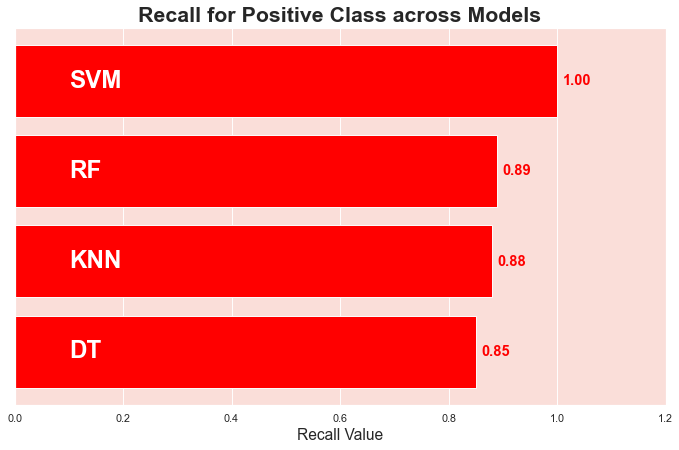

In [79]:
# Sort values based on 'recall_1'
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']

# Plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='red')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0, 1.2])

# Add title and xlabel
plt.title("Recall for Positive Class across Models", fontweight='bold', fontsize=22)
plt.xlabel('Recall Value', fontsize=16)
plt.show()

In [83]:
import os
os.getcwd()


'C:\\Users\\Asus'